### **Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### **Функция для оценки работы модели**

In [4]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

### **Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'DATA/train.csv'
TEST_DATASET_PATH = 'DATA/test.csv'

### **Загрузка данных**

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH).set_index('Id')
display(train_df.tail())
print(train_df.shape)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
77,32,2.00000,50.40178,30.47620,5.00000,6,5.00000,1968,0.13565,B,B,46,7960,6,350.00000,3,11,B,196684.31604
6159,18,1.00000,41.52155,20.53922,9.00000,13,13.00000,2000,0.00000,B,B,30,5562,0,nan,0,5,A,189050.28957
5123,27,1.00000,47.93901,nan,1.00000,12,16.00000,2015,0.07216,B,B,2,629,1,nan,0,0,A,159143.80537
5400,75,2.00000,43.60256,33.84015,8.00000,1,5.00000,1961,0.30747,B,A,30,5048,9,325.00000,2,5,B,181595.33981
6306,128,1.00000,38.66664,21.15787,8.00000,7,17.00000,1990,0.00000,B,B,27,4798,0,30.00000,2,8,B,218714.07762


(10000, 19)


In [7]:
train_idxs = list(train_df.index)

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH).set_index('Id')
display(test_df.head())
print(test_df.shape)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00000,49.88264,33.43278,6.00000,6,14.00000,1972,0.31020,B,B,11,2748,1,nan,0,0,B
15856,74,2.00000,69.26318,nan,1.00000,6,1.00000,1977,0.07578,B,B,6,1437,3,nan,0,2,B
5480,190,1.00000,13.59782,15.94825,12.00000,2,5.00000,1909,0.00000,B,B,30,7538,87,4702.00000,5,5,B
15664,47,2.00000,73.04661,51.94084,9.00000,22,22.00000,2007,0.10187,B,B,23,4583,3,nan,3,3,B
14275,27,1.00000,47.52711,43.38757,1.00000,17,17.00000,2017,0.07216,B,B,2,629,1,nan,0,0,A


(5000, 18)


In [9]:
# Сразу создаем датафрейм для результатов на тесте (изначально он пустой)
preds_final = pd.DataFrame()
preds_final['Id'] = test_df.index

### **Приведение типов**

In [10]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### **Обзор Данных**

In [12]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.00000,7887.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,5202.00000,10000.00000,10000.00000,10000.00000
mean,1.89050,56.31578,37.19964,6.27330,8.52670,12.60940,3990.16630,0.11886,24.68700,5352.15740,8.03920,1142.90446,1.31950,4.23130,214138.85740
std,0.83951,21.05873,86.24121,28.56092,5.24115,6.77597,200500.26143,0.11903,17.53261,4006.79980,23.83187,1021.51726,1.49360,4.80634,92872.29387
min,0.00000,1.13686,0.37062,0.00000,1.00000,0.00000,1910.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,1.00000,41.77488,22.76983,1.00000,4.00000,9.00000,1974.00000,0.01765,6.00000,1564.00000,0.00000,350.00000,0.00000,1.00000,153872.63394
50%,2.00000,52.51331,32.78126,6.00000,7.00000,13.00000,1977.00000,0.07542,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000,192269.64488
75%,2.00000,65.90063,45.12880,9.00000,12.00000,17.00000,2001.00000,0.19578,36.00000,7227.00000,5.00000,1548.00000,2.00000,6.00000,249135.46217
max,19.00000,641.06519,7480.59213,2014.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


In [13]:
train_df.describe(include=['O'])

,DistrictId,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000,10000
unique,205,2,2,2
top,27,B,B,B
freq,851,9903,9725,9175


### **Обработка выбросов**

**Rooms**

In [14]:
train_df['Rooms'].value_counts()

2.00000     3880
1.00000     3705
3.00000     2235
4.00000      150
5.00000       18
0.00000        8
10.00000       2
19.00000       1
6.00000        1
Name: Rooms, dtype: int64

In [15]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

In [16]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.00000,7887.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,5202.00000,10000.00000,10000.00000,10000.00000
mean,1.88880,56.31578,37.19964,6.27330,8.52670,12.60940,3990.16630,0.11886,24.68700,5352.15740,8.03920,1142.90446,1.31950,4.23130,214138.85740
std,0.81210,21.05873,86.24121,28.56092,5.24115,6.77597,200500.26143,0.11903,17.53261,4006.79980,23.83187,1021.51726,1.49360,4.80634,92872.29387
min,1.00000,1.13686,0.37062,0.00000,1.00000,0.00000,1910.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,1.00000,41.77488,22.76983,1.00000,4.00000,9.00000,1974.00000,0.01765,6.00000,1564.00000,0.00000,350.00000,0.00000,1.00000,153872.63394
50%,2.00000,52.51331,32.78126,6.00000,7.00000,13.00000,1977.00000,0.07542,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000,192269.64488
75%,2.00000,65.90063,45.12880,9.00000,12.00000,17.00000,2001.00000,0.19578,36.00000,7227.00000,5.00000,1548.00000,2.00000,6.00000,249135.46217
max,6.00000,641.06519,7480.59213,2014.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [18]:
train_df.loc[train_df['Square'] < 20, 'Square'] = 20
train_df.loc[train_df['Square'] > 120, 'Square'] = 120

In [19]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.00000,7887.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,5202.00000,10000.00000,10000.00000,10000.00000
mean,1.88880,56.01175,37.19964,6.27330,8.52670,12.60940,3990.16630,0.11886,24.68700,5352.15740,8.03920,1142.90446,1.31950,4.23130,214138.85740
std,0.81210,18.18079,86.24121,28.56092,5.24115,6.77597,200500.26143,0.11903,17.53261,4006.79980,23.83187,1021.51726,1.49360,4.80634,92872.29387
min,1.00000,20.00000,0.37062,0.00000,1.00000,0.00000,1910.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,1.00000,41.77488,22.76983,1.00000,4.00000,9.00000,1974.00000,0.01765,6.00000,1564.00000,0.00000,350.00000,0.00000,1.00000,153872.63394
50%,2.00000,52.51331,32.78126,6.00000,7.00000,13.00000,1977.00000,0.07542,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000,192269.64488
75%,2.00000,65.90063,45.12880,9.00000,12.00000,17.00000,2001.00000,0.19578,36.00000,7227.00000,5.00000,1548.00000,2.00000,6.00000,249135.46217
max,6.00000,120.00000,7480.59213,2014.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


In [20]:
train_df.loc[train_df['LifeSquare'] < 13, 'LifeSquare'] = 13
train_df.loc[train_df['LifeSquare'] > 90, 'LifeSquare'] = 90

In [21]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.00000,7887.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,5202.00000,10000.00000,10000.00000,10000.00000
mean,1.88880,56.01175,36.05819,6.27330,8.52670,12.60940,3990.16630,0.11886,24.68700,5352.15740,8.03920,1142.90446,1.31950,4.23130,214138.85740
std,0.81210,18.18079,16.15393,28.56092,5.24115,6.77597,200500.26143,0.11903,17.53261,4006.79980,23.83187,1021.51726,1.49360,4.80634,92872.29387
min,1.00000,20.00000,13.00000,0.00000,1.00000,0.00000,1910.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,1.00000,41.77488,22.76983,1.00000,4.00000,9.00000,1974.00000,0.01765,6.00000,1564.00000,0.00000,350.00000,0.00000,1.00000,153872.63394
50%,2.00000,52.51331,32.78126,6.00000,7.00000,13.00000,1977.00000,0.07542,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000,192269.64488
75%,2.00000,65.90063,45.12880,9.00000,12.00000,17.00000,2001.00000,0.19578,36.00000,7227.00000,5.00000,1548.00000,2.00000,6.00000,249135.46217
max,6.00000,120.00000,90.00000,2014.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


In [22]:
train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4
train_df.loc[train_df['KitchenSquare'] > 25, 'KitchenSquare'] = 25

In [23]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.00000,7887.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,5202.00000,10000.00000,10000.00000,10000.00000
mean,1.88880,56.01175,36.05819,6.78520,8.52670,12.60940,3990.16630,0.11886,24.68700,5352.15740,8.03920,1142.90446,1.31950,4.23130,214138.85740
std,0.81210,18.18079,16.15393,2.96127,5.24115,6.77597,200500.26143,0.11903,17.53261,4006.79980,23.83187,1021.51726,1.49360,4.80634,92872.29387
min,1.00000,20.00000,13.00000,4.00000,1.00000,0.00000,1910.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,1.00000,41.77488,22.76983,4.00000,4.00000,9.00000,1974.00000,0.01765,6.00000,1564.00000,0.00000,350.00000,0.00000,1.00000,153872.63394
50%,2.00000,52.51331,32.78126,6.00000,7.00000,13.00000,1977.00000,0.07542,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000,192269.64488
75%,2.00000,65.90063,45.12880,9.00000,12.00000,17.00000,2001.00000,0.19578,36.00000,7227.00000,5.00000,1548.00000,2.00000,6.00000,249135.46217
max,6.00000,120.00000,90.00000,25.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


**HouseFloor, Floor**

In [24]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [25]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [26]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

**House year**

In [27]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [28]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2005

In [29]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### **Обработка пропусков**

In [30]:
train_df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [31]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
Id,,,
14038,47.98156,29.44275,6.00000
15053,65.68364,40.04954,8.00000
4765,44.94795,29.19761,4.00000
5809,53.35298,52.73151,9.00000
10783,39.64919,23.77617,7.00000
12915,80.38448,46.68372,12.00000
14549,62.25411,37.16038,7.00000
11993,80.31293,nan,4.00000
5172,64.51144,nan,4.00000


In [32]:
# медиана до корректировки
train_df['LifeSquare'].median()

32.781260192155735

In [33]:
# медиана расхождения площадей
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.39334071442952

In [34]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    train_df.loc[train_df['LifeSquare'].isnull(), 'Square']
    - train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_med_diff
)

In [35]:
train_df['LifeSquare'].median()

33.681153490310095

In [36]:
train_df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [37]:
train_df.drop(['Healthcare_1'], axis='columns', inplace=True)

In [38]:
train_df.isnull().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

### Mean Encoding

**MedPriceByDistrict**

In [39]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.00000,142799.43405
1,0,2.00000,176210.81233
2,0,3.00000,300610.35942
3,1,1.00000,146735.67174
4,1,2.00000,202666.31013


In [40]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
0,35,2.00000,47.98156,29.44275,6.00000,7,9.00000,1969,0.08904,B,B,33,7976,5,0,11,B,184966.93073,207786.13584
1,41,3.00000,65.68364,40.04954,8.00000,7,9.00000,1978,0.00007,B,B,46,10309,1,1,16,B,300009.45006,300009.45006
2,53,2.00000,44.94795,29.19761,4.00000,8,12.00000,1968,0.04964,B,B,34,7759,0,1,3,B,220925.90852,263206.22315
3,58,2.00000,53.35298,52.73151,9.00000,8,17.00000,1977,0.43789,B,B,23,5735,3,0,5,B,175616.22722,166809.66564
4,99,1.00000,39.64919,23.77617,7.00000,11,12.00000,1976,0.01234,B,B,35,5776,1,2,4,B,150226.53164,158539.05272


In [41]:
train_df['MedPriceByDistrict'].isnull().sum()

0

### **Отбор признаков**

In [42]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'MedPriceByDistrict']

In [43]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1']

new_feature_names = ['MedPriceByDistrict']

target_name = 'Price'

### Разбиение на train и val

In [44]:
train_df.drop(columns=['Ecology_2', 'Ecology_3', 'Shops_2', 'DistrictId'], axis='columns', inplace=True)

In [45]:
train_df.dtypes

Rooms                 float64
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                   int64
HouseFloor            float64
HouseYear               int64
Ecology_1             float64
Social_1                int64
Social_2                int64
Social_3                int64
Helthcare_2             int64
Shops_1                 int64
Price                 float64
MedPriceByDistrict    float64
dtype: object

In [46]:
display(train_df.tail())

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,MedPriceByDistrict
9995,2.00000,50.40178,30.47620,5.00000,6,5.00000,1968,0.13565,46,7960,6,3,11,196684.31604,233599.11598
9996,1.00000,41.52155,20.53922,9.00000,13,13.00000,2000,0.00000,30,5562,0,0,5,189050.28957,171162.17990
9997,1.00000,47.93901,32.54567,4.00000,12,16.00000,2015,0.07216,2,629,1,0,0,159143.80537,118327.09062
9998,2.00000,43.60256,33.84015,8.00000,1,5.00000,1961,0.30747,30,5048,9,2,5,181595.33981,187966.41908
9999,1.00000,38.66664,21.15787,8.00000,7,17.00000,1990,0.00000,27,4798,0,2,8,218714.07762,178780.60624


In [47]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [49]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,MedPriceByDistrict
9185,1.00000,39.83774,23.28137,7.00000,13,17.00000,2010,0.00766,35,7077,56,3,19,254129.93256
6945,2.00000,20.00000,4.60666,4.00000,4,20.00000,1977,0.07216,2,629,1,0,0,178912.36908
6615,1.00000,44.84656,21.58987,8.00000,3,14.00000,2004,0.00000,36,6714,2,0,2,181165.00558
9527,2.00000,52.44986,27.14581,7.00000,3,5.00000,1953,0.16909,19,3856,10,2,5,232216.75202
4336,3.00000,65.52154,39.97374,8.00000,5,9.00000,1976,0.16909,19,3856,10,2,5,354709.71117


In [50]:
X_train.shape

(7000, 14)

### Построение модели

**Обучение и настройка модели**

In [51]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.966
Valid R2:	0.754


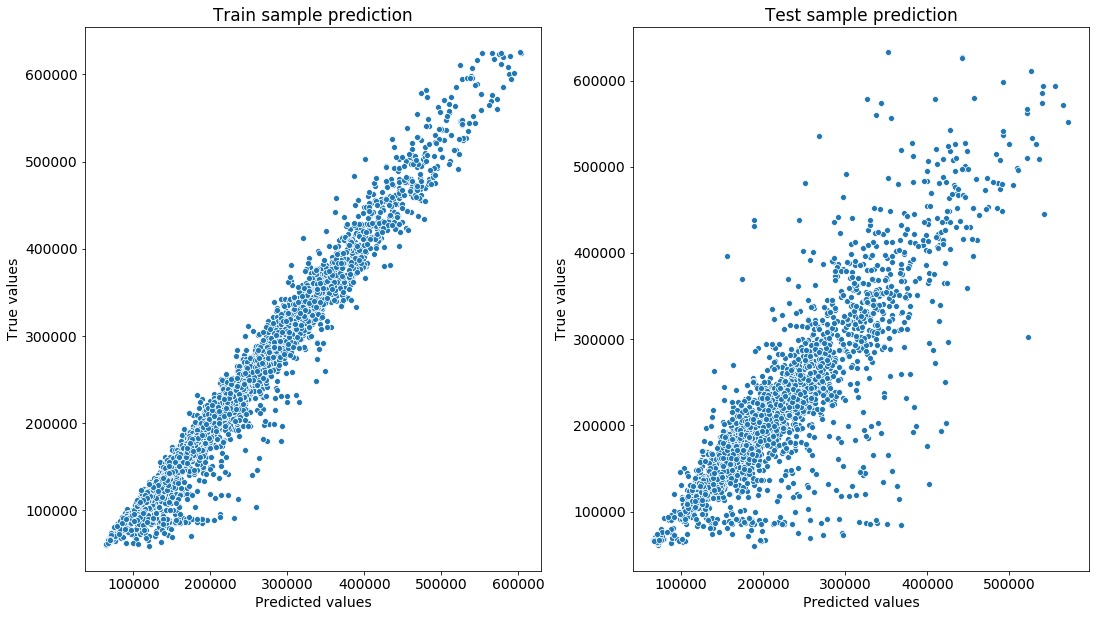

In [52]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_val)

evaluate_preds(y_train, y_train_preds, y_val, y_test_preds)

**Перекрестная проверка**

In [53]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.77209096, 0.73525528, 0.74061069, 0.76945172, 0.75514706])

In [54]:
cv_score.mean()

0.7545111420696599

In [55]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
13,MedPriceByDistrict,0.62119
1,Square,0.12647
2,LifeSquare,0.03146
6,HouseYear,0.03146
3,KitchenSquare,0.02938
4,Floor,0.02882
10,Social_3,0.02876
5,HouseFloor,0.02563
9,Social_2,0.01949
7,Ecology_1,0.01800


## Обработка тестового Датасета

#### Приведение типов

In [56]:
test_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [57]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

### Обработка выбросов

**Rooms**

In [58]:
test_df['Rooms'].value_counts()

2.00000     2030
1.00000     1769
3.00000     1099
4.00000       90
5.00000        7
0.00000        2
6.00000        2
17.00000       1
Name: Rooms, dtype: int64

In [59]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = test_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

In [60]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.00000,3959.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,2623.00000,5000.00000,5000.00000
mean,1.90780,56.44950,36.15881,5.97680,8.63200,12.60100,1984.39260,0.11987,24.93380,5406.90000,8.26260,1146.65726,1.31940,4.24280
std,0.81008,19.09279,17.82529,9.95002,5.48323,6.78921,18.57315,0.12007,17.53220,4026.61477,23.86376,1044.74423,1.47994,4.77736
min,1.00000,1.37854,0.33349,0.00000,1.00000,0.00000,1908.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,41.90623,23.09203,1.00000,4.00000,9.00000,1973.00000,0.01951,6.00000,1564.00000,0.00000,325.00000,0.00000,1.00000
50%,2.00000,52.92134,32.92509,6.00000,7.00000,12.00000,1977.00000,0.07216,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000
75%,2.00000,66.28513,45.17409,9.00000,12.00000,17.00000,2000.00000,0.19578,36.00000,7287.00000,5.00000,1548.00000,2.00000,6.00000
max,6.00000,223.45369,303.07109,620.00000,78.00000,99.00000,2020.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000


In [61]:
test_df.loc[test_df['Square'] < 20, 'Square'] = 20
test_df.loc[test_df['Square'] > 120, 'Square'] = 120

In [62]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.00000,3959.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,2623.00000,5000.00000,5000.00000
mean,1.90780,56.30069,36.15881,5.97680,8.63200,12.60100,1984.39260,0.11987,24.93380,5406.90000,8.26260,1146.65726,1.31940,4.24280
std,0.81008,18.17159,17.82529,9.95002,5.48323,6.78921,18.57315,0.12007,17.53220,4026.61477,23.86376,1044.74423,1.47994,4.77736
min,1.00000,20.00000,0.33349,0.00000,1.00000,0.00000,1908.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,41.90623,23.09203,1.00000,4.00000,9.00000,1973.00000,0.01951,6.00000,1564.00000,0.00000,325.00000,0.00000,1.00000
50%,2.00000,52.92134,32.92509,6.00000,7.00000,12.00000,1977.00000,0.07216,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000
75%,2.00000,66.28513,45.17409,9.00000,12.00000,17.00000,2000.00000,0.19578,36.00000,7287.00000,5.00000,1548.00000,2.00000,6.00000
max,6.00000,120.00000,303.07109,620.00000,78.00000,99.00000,2020.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000


In [63]:
test_df.loc[test_df['LifeSquare'] < 13, 'LifeSquare'] = 13
test_df.loc[test_df['LifeSquare'] > 90, 'LifeSquare'] = 90

In [64]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.00000,3959.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,2623.00000,5000.00000,5000.00000
mean,1.90780,56.30069,36.17136,5.97680,8.63200,12.60100,1984.39260,0.11987,24.93380,5406.90000,8.26260,1146.65726,1.31940,4.24280
std,0.81008,18.17159,16.03606,9.95002,5.48323,6.78921,18.57315,0.12007,17.53220,4026.61477,23.86376,1044.74423,1.47994,4.77736
min,1.00000,20.00000,13.00000,0.00000,1.00000,0.00000,1908.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,41.90623,23.09203,1.00000,4.00000,9.00000,1973.00000,0.01951,6.00000,1564.00000,0.00000,325.00000,0.00000,1.00000
50%,2.00000,52.92134,32.92509,6.00000,7.00000,12.00000,1977.00000,0.07216,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000
75%,2.00000,66.28513,45.17409,9.00000,12.00000,17.00000,2000.00000,0.19578,36.00000,7287.00000,5.00000,1548.00000,2.00000,6.00000
max,6.00000,120.00000,90.00000,620.00000,78.00000,99.00000,2020.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000


In [65]:
test_df.loc[test_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4
test_df.loc[test_df['KitchenSquare'] > 25, 'KitchenSquare'] = 25

In [66]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.00000,3959.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,5000.00000,2623.00000,5000.00000,5000.00000
mean,1.90780,56.30069,36.17136,6.75180,8.63200,12.60100,1984.39260,0.11987,24.93380,5406.90000,8.26260,1146.65726,1.31940,4.24280
std,0.81008,18.17159,16.03606,2.86109,5.48323,6.78921,18.57315,0.12007,17.53220,4026.61477,23.86376,1044.74423,1.47994,4.77736
min,1.00000,20.00000,13.00000,4.00000,1.00000,0.00000,1908.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,41.90623,23.09203,4.00000,4.00000,9.00000,1973.00000,0.01951,6.00000,1564.00000,0.00000,325.00000,0.00000,1.00000
50%,2.00000,52.92134,32.92509,6.00000,7.00000,12.00000,1977.00000,0.07216,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000
75%,2.00000,66.28513,45.17409,9.00000,12.00000,17.00000,2000.00000,0.19578,36.00000,7287.00000,5.00000,1548.00000,2.00000,6.00000
max,6.00000,120.00000,90.00000,25.00000,78.00000,99.00000,2020.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000


**HouseFloor, Floor**

In [67]:
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [68]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [69]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

**House year**

In [70]:
test_df['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [71]:
# Неправильных значений нет, никаких действий не производим

### **Обработка пропусков**

In [72]:
test_df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [73]:
test_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
Id,,,
725,49.88264,33.43278,6.00000
15856,69.26318,nan,4.00000
5480,20.00000,15.94825,12.00000
15664,73.04661,51.94084,9.00000
14275,47.52711,43.38757,4.00000
7633,40.67563,nan,4.00000
13329,68.09954,64.84303,4.00000
5502,48.19390,32.85764,6.00000
4220,72.27711,45.96876,9.00000


In [74]:
# медиана до корректировки
test_df['LifeSquare'].median()

32.92508663208161

In [75]:
# медиана расхождения площадей
square_med_diff = (test_df.loc[test_df['LifeSquare'].notnull(), 'Square']
                   - test_df.loc[test_df['LifeSquare'].notnull(), 'LifeSquare']
                   - test_df.loc[test_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.419995446781297

In [76]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    test_df.loc[test_df['LifeSquare'].isnull(), 'Square']
    - test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_med_diff
)

In [77]:
test_df['LifeSquare'].median()

33.9564494602982

In [78]:
test_df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [79]:
test_df.drop(['Healthcare_1'], axis='columns', inplace=True)

In [80]:
test_df.isnull().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

**Mean Encoding**

**MedPriceByDistrict**

In [81]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
0,58,2.00000,49.88264,33.43278,6.00000,6,14.00000,1972,0.31020,B,B,11,2748,1,0,0,B,166809.66564
1,74,2.00000,69.26318,53.84319,4.00000,6,1.00000,1977,0.07578,B,B,6,1437,3,0,2,B,243031.69553
2,190,1.00000,20.00000,15.94825,12.00000,2,5.00000,1909,0.00000,B,B,30,7538,87,5,5,B,nan
3,47,2.00000,73.04661,51.94084,9.00000,22,22.00000,2007,0.10187,B,B,23,4583,3,3,3,B,222227.58421
4,27,1.00000,47.52711,43.38757,4.00000,17,17.00000,2017,0.07216,B,B,2,629,1,0,0,A,118327.09062


In [82]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DistrictId          5000 non-null   object 
 1   Rooms               5000 non-null   float64
 2   Square              5000 non-null   float64
 3   LifeSquare          5000 non-null   float64
 4   KitchenSquare       5000 non-null   float64
 5   Floor               5000 non-null   int64  
 6   HouseFloor          5000 non-null   float64
 7   HouseYear           5000 non-null   int64  
 8   Ecology_1           5000 non-null   float64
 9   Ecology_2           5000 non-null   object 
 10  Ecology_3           5000 non-null   object 
 11  Social_1            5000 non-null   int64  
 12  Social_2            5000 non-null   int64  
 13  Social_3            5000 non-null   int64  
 14  Helthcare_2         5000 non-null   int64  
 15  Shops_1             5000 non-null   int64  
 16  Shops_

In [83]:
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_df['MedPriceByDistrict'].median()

In [84]:
test_df.isnull().sum()

DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
MedPriceByDistrict    0
dtype: int64

### **Отбор признаков**

In [85]:
test_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'MedPriceByDistrict']

In [86]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1']

new_feature_names = ['MedPriceByDistrict']

target_name = 'Price'

In [87]:
### Дополнительно удаляем колонки
test_df.drop(columns=['Ecology_2', 'Ecology_3', 'Shops_2', 'DistrictId'], axis='columns', inplace=True)

In [88]:
test_df.dtypes

Rooms                 float64
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                   int64
HouseFloor            float64
HouseYear               int64
Ecology_1             float64
Social_1                int64
Social_2                int64
Social_3                int64
Helthcare_2             int64
Shops_1                 int64
MedPriceByDistrict    float64
dtype: object

In [89]:
display(test_df.tail())

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,MedPriceByDistrict
4995,3.00000,67.13391,50.80980,6.00000,5,9.00000,1973,0.00017,36,5992,0,1,1,247249.09087
4996,1.00000,40.19847,21.80706,10.00000,12,17.00000,2017,0.00712,1,264,0,0,1,146735.67174
4997,3.00000,77.84218,48.28263,9.00000,23,22.00000,1989,0.09080,74,19083,2,5,15,315198.84263
4998,2.00000,81.30522,65.88523,4.00000,4,12.00000,1977,0.07216,2,629,1,0,0,178912.36908
4999,2.00000,60.55569,45.13570,4.00000,10,17.00000,1977,0.00008,22,6398,141,3,23,177914.71579


In [90]:
X1 = test_df[feature_names + new_feature_names]

In [91]:
X1.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,MedPriceByDistrict
0,2.00000,49.88264,33.43278,6.00000,6,14.00000,1972,0.31020,11,2748,1,0,0,166809.66564
1,2.00000,69.26318,53.84319,4.00000,6,1.00000,1977,0.07578,6,1437,3,0,2,243031.69553
2,1.00000,20.00000,15.94825,12.00000,2,5.00000,1909,0.00000,30,7538,87,5,5,197049.23108
3,2.00000,73.04661,51.94084,9.00000,22,22.00000,2007,0.10187,23,4583,3,3,3,222227.58421
4,1.00000,47.52711,43.38757,4.00000,17,17.00000,2017,0.07216,2,629,1,0,0,118327.09062


In [92]:
X1.shape

(5000, 14)

In [93]:
X1.isnull().sum()

Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
MedPriceByDistrict    0
dtype: int64

## Предсказание цен на тестовом датасете

In [94]:
y_preds = rf_model.predict(X1)

In [95]:
preds_final['Price'] = y_preds

In [96]:
preds_final.head(10)

,Id,Price
0,725,162955.83582
1,15856,223947.28724
2,5480,239554.17549
3,15664,291437.17062
4,14275,148686.29401
5,7633,220770.68787
6,13329,178676.83777
7,5502,226343.35584
8,4220,296670.25609
9,11538,210678.93210


In [97]:
preds_final.to_csv('KARepin_predictions.csv', index=False)